In [2]:
%load_ext autoreload
%autoreload 2

In [48]:
from embcomp.test_cases.utils import plot
from embcomp.test_cases.neighborhood import plot_neighborhood

def gather_test_cases():
    import embcomp.test_cases.neighborhood as mod
    return [
        getattr(mod, name)
        for name in filter(lambda x: x.startswith("case"), dir(mod))
    ]

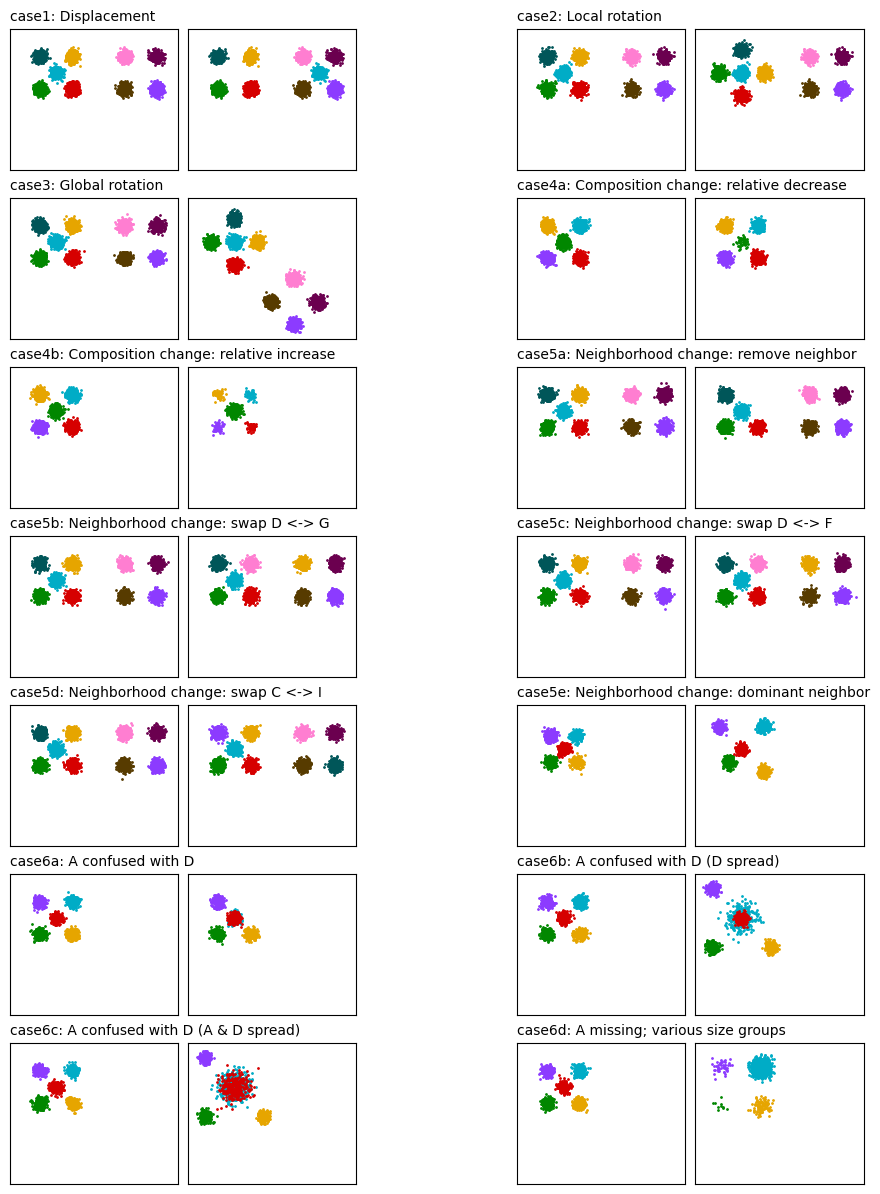

In [80]:
import matplotlib.pyplot as plt
from math import ceil

cases = gather_test_cases()

fig, axs = plt.subplots(ncols=2, nrows=ceil(len(cases) / 2), figsize=(12, 15), sharex=True, sharey=True)

for ax, case in zip(axs.flat, cases):
    ax.set_title(f"{case.__name__}: {case.__doc__}", fontsize='medium', loc='left') 
    plot(*case(), ax=ax)

## Testing

In [121]:
def run(metrics):
    cases = gather_test_cases()
    for case in cases:
        plot_neighborhood(*case(), metrics=metrics)

### Fixed _k_

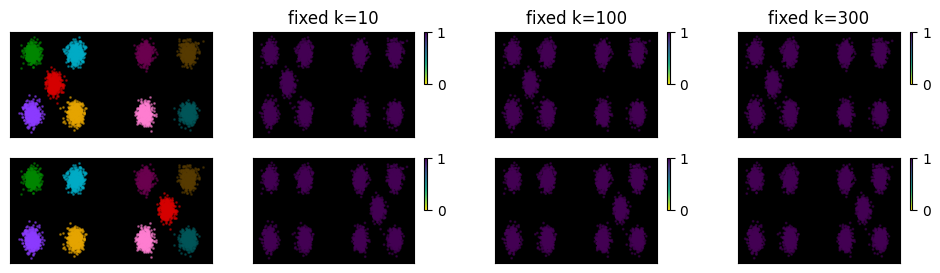

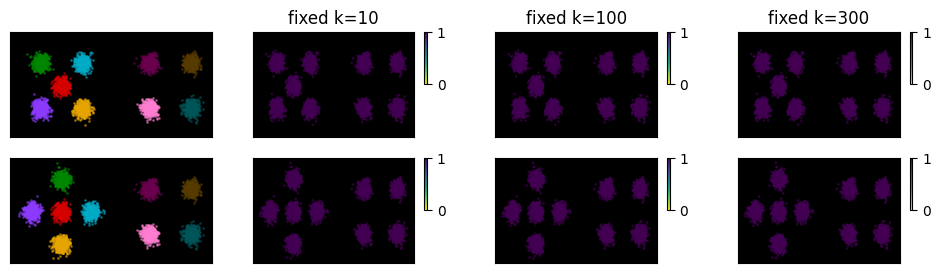

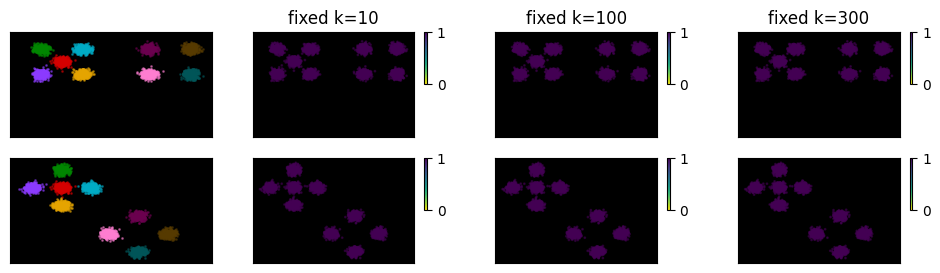

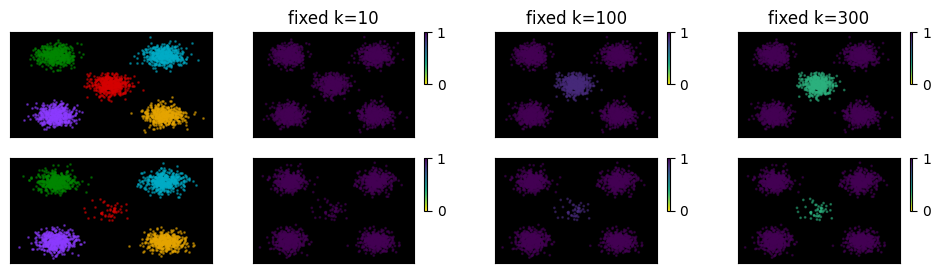

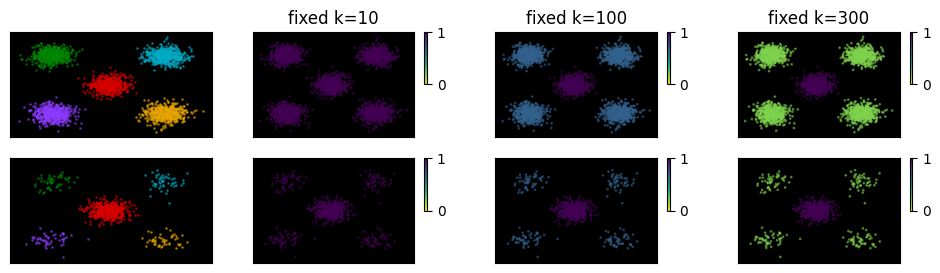

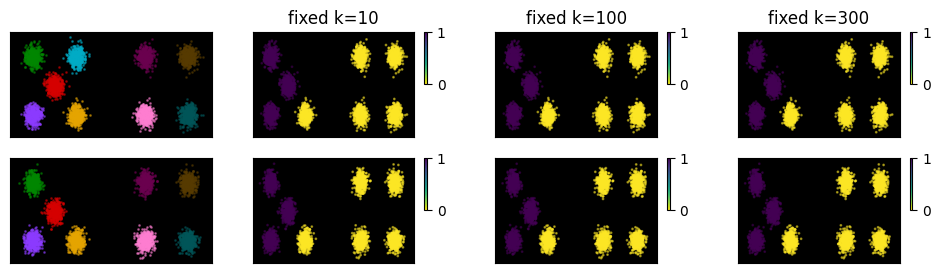

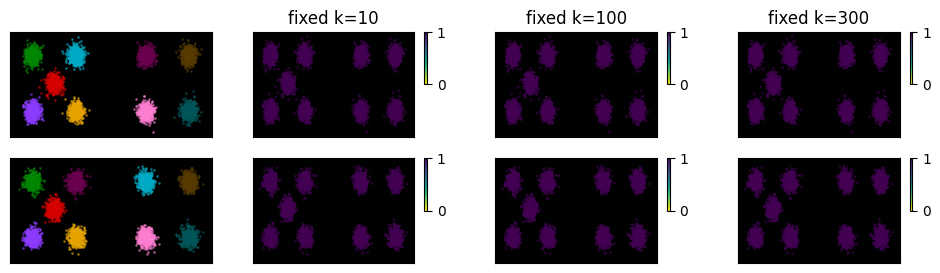

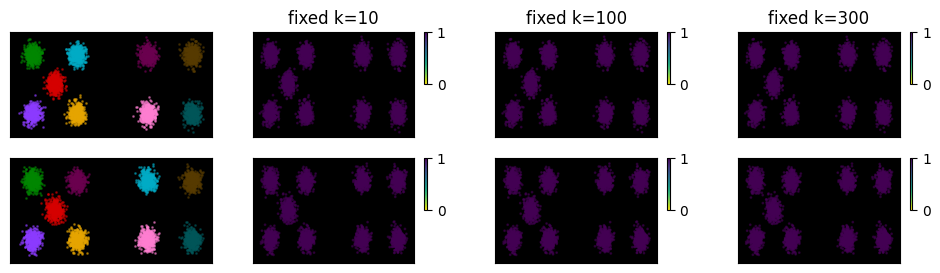

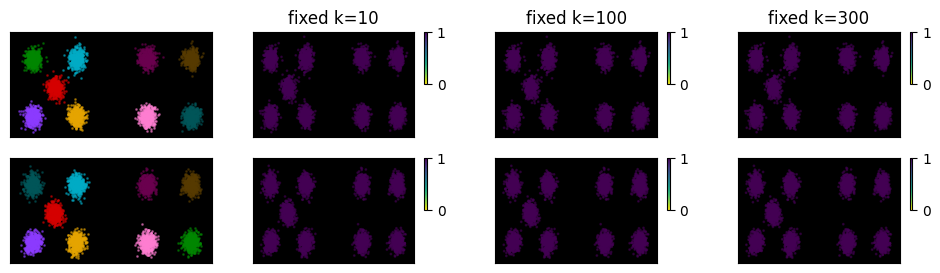

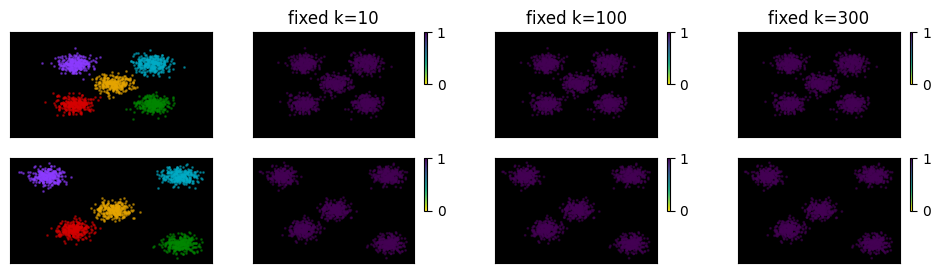

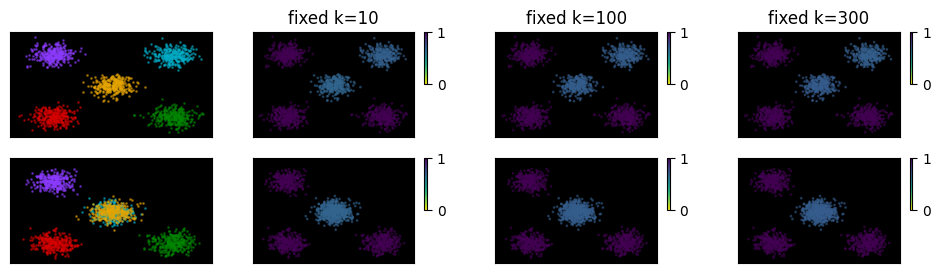

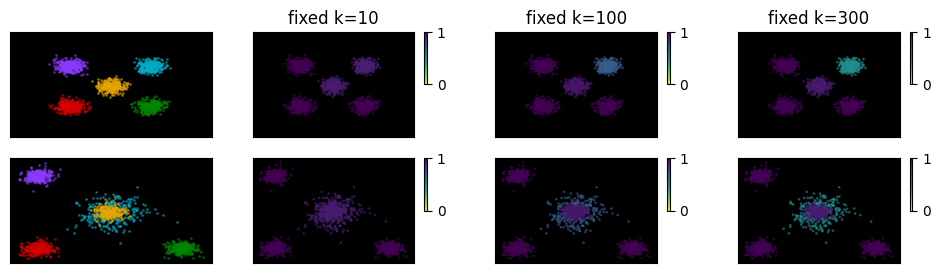

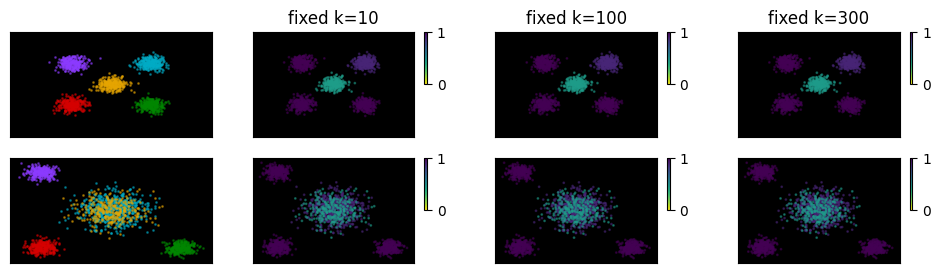

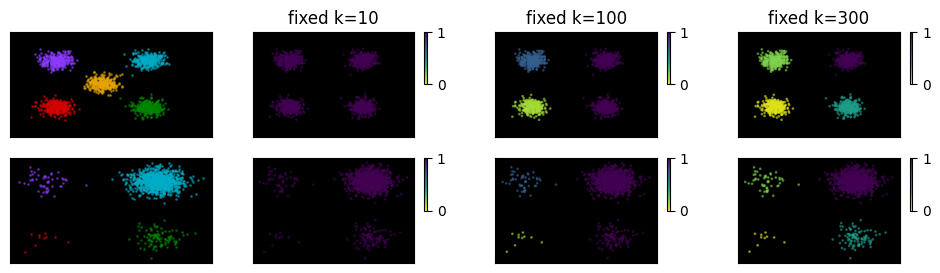

In [125]:
import functools

import pandas as pd
from sklearn.neighbors import NearestNeighbors

from embcomp.metrics import count_neighbor_labels

def fixed_k(data: pd.DataFrame, k):
    nn = NearestNeighbors(n_neighbors=k).fit(data[["x", "y"]])
    knn_indices = nn.kneighbors(return_distance=False)
    counts = count_neighbor_labels(knn_indices, data.label)
    index = pd.Series(data.label, name="label", dtype="category")
    df = pd.DataFrame(counts, index=index).groupby("label").sum()
    df.columns = df.index
    return df


run([
    ("fixed k=10", functools.partial(fixed_k, k=10)),
    ("fixed k=100", functools.partial(fixed_k, k=100)),
    ("fixed k=300", functools.partial(fixed_k, k=300)),
])